In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [101]:
# Load dataset
file_path = "../../data/ethusd_group_project.csv"
df = pd.read_csv(file_path, parse_dates=['time'])

# Ensure time is sorted
df = df.sort_values(by="time")

# Set time as index
df.set_index('time', inplace=True)

# Remove NaN values
df = df.dropna()

### Train-Test Split (without validation)

In [102]:
# Train-Test Split (80% train, 20% test)
train_size = int(0.8 * len(df))
r_train, r_test = df['daily_return'][:train_size], df['daily_return'][train_size:]
RV_train, RV_test = df['RV_d,t'][:train_size], df['RV_d,t'][train_size:]
train_size = len(r_train)
test_size = len(r_test)

print("Training Set:", r_train.shape, RV_train.shape)
print("Test Set:", r_test.shape, RV_test.shape)
print(r_train.index[0])
print(r_test.index[0])

Training Set: (2091,) (2091,)
Test Set: (523,) (523,)
2016-07-01 00:00:00
2022-04-30 00:00:00


#### Use Garch(1,1)

$ \sigma^2_t = \omega + \alpha r^{2}_{t-1} + \beta RV_{d, t-1} $

#### Training

In [103]:
p = 1
q = 1
model = arch_model(r_train, vol='Garch', p=p, q=q, rescale=False)
garch_fit = model.fit(disp="off")
params = garch_fit.params
omega = params['omega']
alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
beta = [params[f'beta[{i+1}]'] for i in range(q)]

In-sample RMSE=0.001594
In-sample MAPE=17.283265%
In-sample R²=0.963889


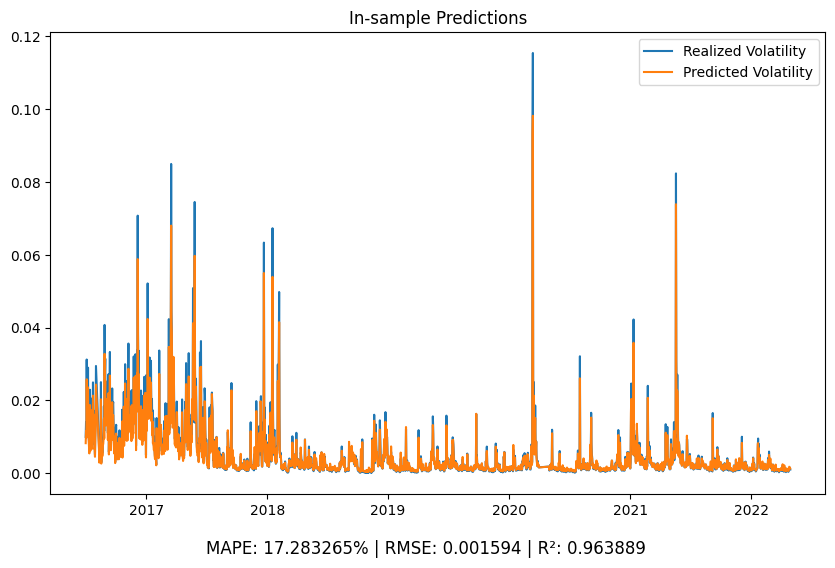

In [104]:
skip = max(p, q)
in_samp_pred = []

for j in range(skip, len(r_train)):
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * (r_train.iloc[j-i] ** 2)
    for i in range(q):
        new_variance += beta[i] * RV_train.iloc[j-i]
    in_samp_pred.append(new_variance) 

# re index
in_samp_pred = pd.Series(in_samp_pred, index=r_train.index[skip:])

# Compute in-sample metrics
rmse = np.sqrt(mean_squared_error(RV_train[skip:], in_samp_pred))
print(f"In-sample RMSE={rmse:.6f}")
mape = mean_absolute_percentage_error(RV_train[skip:], in_samp_pred)
print(f"In-sample MAPE={mape:.6%}")
r2 = r2_score(RV_train[skip:], in_samp_pred)
print(f"In-sample R²={r2:.6f}")

# Plot in-sample predictions
plt.figure(figsize=(10, 6))
plt.plot(RV_train[skip:], label="Realized Volatility")
plt.plot(in_samp_pred, label="Predicted Volatility")
plt.title("In-sample Predictions")
plt.legend()

# Add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, 
            horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/In-Sample GARCH({p}, {q})_plot.png')
plt.show()


In [105]:
# save the GARCH(1,1) in-sample predictions to a csv file
df_in_samp_pred = pd.DataFrame({'Predicted Volatility': in_samp_pred}, index=RV_train[skip:].index)
df_in_samp_pred.to_csv('../../results/models/GARCH_in_sample.csv')

#### Testing

In [106]:
# Get the last conditional variance from training
last_daily_returns = r_train[len(r_train)-p:len(r_train)]
last_variances = RV_train.iloc[len(RV_train)-q:len(RV_train)]

# Initialize list for storing predicted volatility (standard deviation)
predicted_volatility = []

# Compute forcase volatility on the test set
for j in range(len(r_test)):
    r = r_test.iloc[j]
    RV = RV_test.iloc[j]
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
    for i in range(q):
        new_variance += beta[i] * last_variances.iloc[-(1+i)]
    predicted_volatility.append(new_variance)
    # Update for next step
    last_variances = last_variances.shift(-1)
    last_variances.iloc[-1] = RV
    last_daily_returns = last_daily_returns.shift(-1)
    last_daily_returns.iloc[-1] = r 

predicted_volatility = pd.Series(predicted_volatility, index=r_test.index)

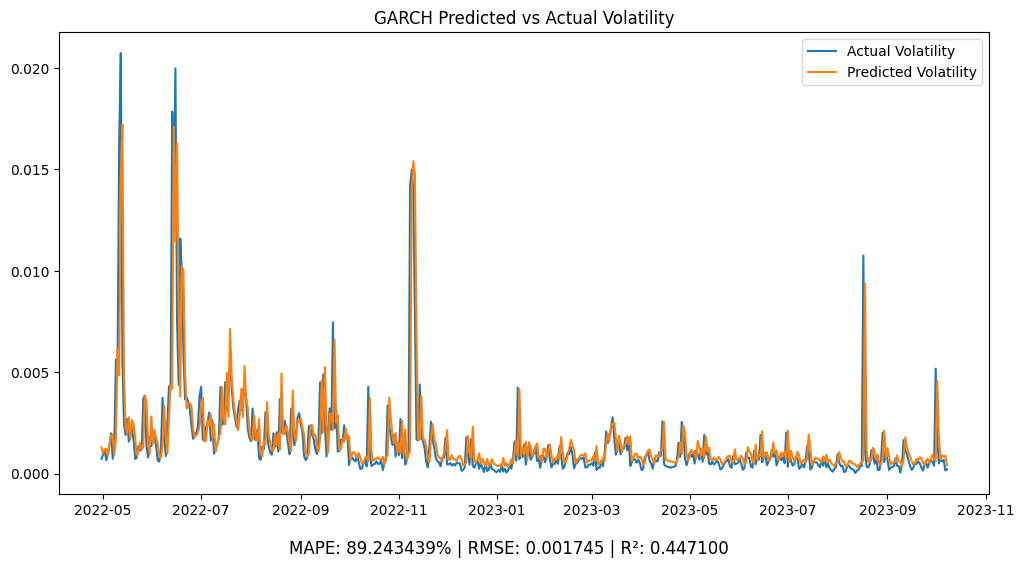

In [107]:
# Compute out-of-sample metrics
rmse = np.sqrt(mean_squared_error(RV_test, predicted_volatility))
mape = mean_absolute_percentage_error(RV_test, predicted_volatility)
r2 = r2_score(RV_test, predicted_volatility)

# Plot predicted and actual volatility
plt.figure(figsize=(12, 6))
plt.plot(RV_test, label="Actual Volatility")
plt.plot(predicted_volatility, label="Predicted Volatility")
plt.title("GARCH Predicted vs Actual Volatility")
plt.legend()

# Add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, 
            horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/out-of-sample GARCH({p}, {q})_plot.png')
plt.show()

### Train-Test Split (with validation)

In [108]:
# Train-Test Split (80% train, 10% validation, 10% test)
train_size = int(0.8 * len(df))
r_train, r_test = df['daily_return'][:train_size], df['daily_return'][train_size:]
RV_train, RV_test = df['RV_d,t'][:train_size], df['RV_d,t'][train_size:]

# Reserve one part of training data for validation
valid_size = int(len(r_train) * 0.2)  # 20% of training data
r_val, RV_val = r_train[-valid_size:], RV_train[-valid_size:]
r_train, RV_train = r_train[:-valid_size], RV_train[:-valid_size]

# Remove NaN values
r_train = r_train.dropna()
RV_train = RV_train.dropna()
train_size = len(r_train)

print("Training Set:", r_train.shape, RV_train.shape)
print("Validation Set:", r_val.shape, RV_val.shape)
print("Test Set:", r_test.shape, RV_test.shape)

Training Set: (1673,) (1673,)
Validation Set: (418,) (418,)
Test Set: (523,) (523,)


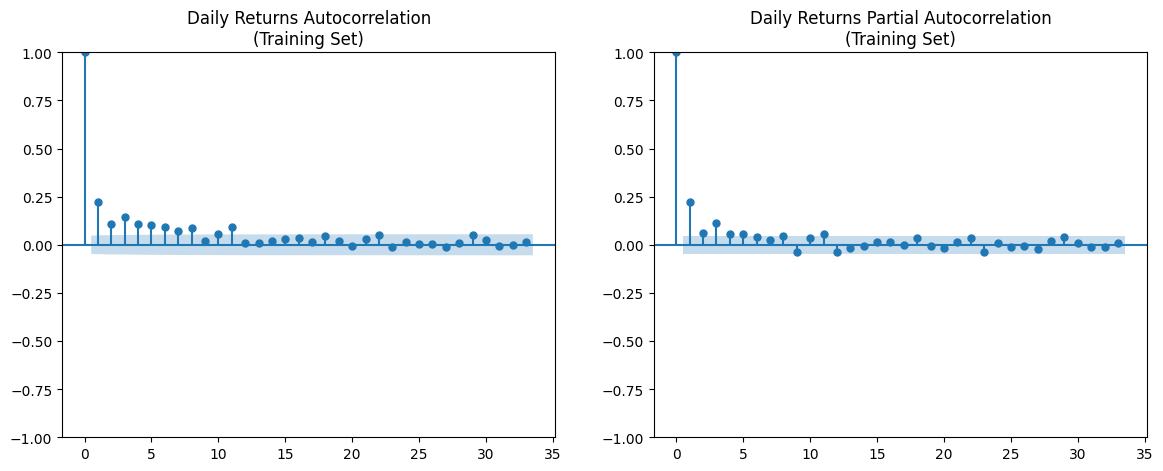

In [109]:
# Visualize the ACF and PACF of the returns
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(r_train**2, title='Daily Returns Autocorrelation\n(Training Set)', ax=ax[0])
plot_pacf(r_train**2, title='Daily Returns Partial Autocorrelation\n(Training Set)', ax=ax[1])
plt.show()

#### Optimise p and q

In [110]:
# Store results
results = []

# Define range of p and q values to test
p_range = range(1,5)
q_range = range(1,5)

# Loop over all (p, q) combinations
for p in p_range:
    for q in q_range:
        predicted_volatility = []

        # Get the last conditional variance from training
        last_daily_returns = r_train[train_size-p-1:train_size-1]
        last_variances = df['RV_d,t'].iloc[train_size-q:train_size]
        
        try:
            model = arch_model(r_train, vol='Garch', p=p, q=q, rescale=False)
            garch_fit = model.fit(disp="off")
            params = garch_fit.params
            omega = params['omega']
            alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
            beta = [params[f'beta[{i+1}]'] for i in range(q)]

            # Compute volatility iteratively using GARCH equation
            for j in range(len(r_val)):
                r = r_val.iloc[j]
                RV = RV_val.iloc[j]               
                new_variance = omega
                for i in range(p):
                    new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
                for i in range(q):
                    new_variance += beta[i] * last_variances.iloc[-(1+i)]
                predicted_volatility.append(new_variance)
                # Update for next step
                last_variances = last_variances.shift(-1)
                last_variances.iloc[-1] = RV
                last_daily_returns = last_daily_returns.shift(-1)
                last_daily_returns.iloc[-1] = r 

            # Compute MSE
            mse = mean_squared_error(RV_val, predicted_volatility)
            rmse = np.sqrt(mse)
            mape = mean_absolute_percentage_error(RV_val, predicted_volatility)
            r2 = r2_score(RV_val, predicted_volatility)
            results.append((p, q, mse, rmse, mape, r2))

        except Exception as e:
            print(f"Skipping GARCH({p},{q}) due to error: {e}")

In [111]:
# Convert results to a DataFrame
gm_results = pd.DataFrame(results, columns=['p', 'q', 'MSE', 'RMSE', 'MAPE', 'R2'])

In [112]:
gm_results

,p,q,MSE,RMSE,MAPE,R2
0,1,1,0.000024,0.004866,0.491573,0.049421
1,1,2,0.000021,0.004538,0.493385,0.173129
2,1,3,0.000020,0.004508,0.539868,0.183972
3,1,4,0.000020,0.004508,0.539888,0.183965
4,2,1,0.000024,0.004866,0.491568,0.049409
5,2,2,0.000021,0.004538,0.493378,0.173130
6,2,3,0.000020,0.004498,0.588563,0.187627
7,2,4,0.000020,0.004498,0.588564,0.187627
8,3,1,0.000023,0.004773,0.494394,0.085153
9,3,2,0.000021,0.004569,0.493359,0.161816


In [113]:
# Find the best (p, q) with the lowest RMSE
best_params = gm_results.loc[gm_results['RMSE'].idxmin()]
best_p = best_params['p']
best_q = best_params['q']
best_rmse = best_params['RMSE']
print(f"Best GARCH({best_p},{best_q}) model with RMSE={best_rmse:.6f}")

# Find the best (p, q) with the largest R2
best_params = gm_results.loc[gm_results['R2'].idxmax()]
best_p = best_params['p']
best_q = best_params['q']
best_r2 = best_params['R2']
print(f"Best GARCH({best_p},{best_q}) model with R2={best_r2:.6f}")

Best GARCH(4.0,4.0) model with RMSE=0.004278
Best GARCH(4.0,4.0) model with R2=0.265357


#### Best GARCH Model on Testing Set

In [114]:
# Fit Best GARCH model to the training set
p = int(best_p)
q = int(best_q)
gm_best = arch_model(r_train, p=p, q=q, rescale=False)
gm_best_fit = gm_best.fit(disp='off')

# Extract parameters
params = gm_best_fit.params
omega = params['omega']
alpha = [params[f'alpha[{i+1}]'] for i in range(p)]
beta = [params[f'beta[{i+1}]'] for i in range(q)]
print(f"Estimated Parameters: \nomega={omega:.6f}, \nalpha={alpha}, \nbeta={beta}")

Estimated Parameters: 
omega=0.000286, 
alpha=[0.14460547188139958, 0.04760832732641844, 0.04760833652922008, 0.04760832070865816], 
beta=[0.159800860940897, 0.15980086248973702, 0.1598008637772028, 0.1598008657084237]


In [115]:
# Get the last conditional variance from training
last_daily_returns = r_train[len(r_train)-p:len(r_train)]
last_variances = RV_train.iloc[len(RV_train)-q:len(RV_train)]

# Initialize list for storing predicted volatility (standard deviation)
predicted_volatility = []

# Compute forcase volatility on the test set
for j in range(len(r_test)):
    r = r_test.iloc[j]
    RV = RV_test.iloc[j]
    new_variance = omega
    for i in range(p):
        new_variance += alpha[i] * (last_daily_returns.iloc[-(1+i)] ** 2)
    for i in range(q):
        new_variance += beta[i] * last_variances.iloc[-(1+i)]
    predicted_volatility.append(new_variance)
    # Update for next step
    last_variances = last_variances.shift(-1)
    last_variances.iloc[-1] = RV
    last_daily_returns = last_daily_returns.shift(-1)
    last_daily_returns.iloc[-1] = r 

In [116]:
# Calculate Error Metrics
mse = mean_squared_error(RV_test, predicted_volatility)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(RV_test, predicted_volatility)
r2 = r2_score(RV_test, predicted_volatility)

# Print evaluation metrics
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.6%}")
print(f"R² Score: {r2:.6f}")

Mean Squared Error (MSE): 0.000004
Root Mean Squared Error (RMSE): 0.001922
Mean Absolute Percentage Error (MAPE): 97.527204%
R² Score: 0.329434


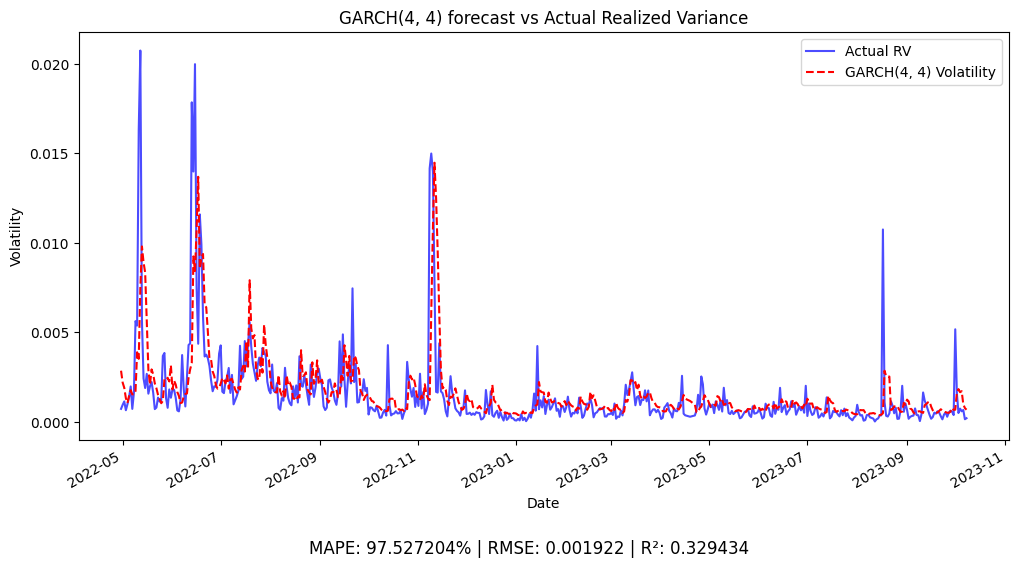

In [117]:
# Create a DataFrame for visualization
df_pred = pd.DataFrame({'Predicted Volatility': predicted_volatility}, index=r_test.index)

# Plot the predicted volatility against the realized volatility on the test set
plt.figure(figsize=(12, 6))
RV_test.plot(label='Actual RV', color="blue", alpha=0.7)
df_pred['Predicted Volatility'].plot(label=f'GARCH({p}, {q}) Volatility', color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.title(f"GARCH({p}, {q}) forecast vs Actual Realized Variance")
plt.legend()

# Add captions
plt.figtext(0.5, 0.01, f"MAPE: {mape:.6%} | RMSE: {rmse:.6f} | R²: {r2:.6f}", wrap=True, horizontalalignment='center', fontsize=12)
plt.savefig(f'../../results/figures/GARCH({p}, {q})_plot.png')
plt.show()

# Save the results to a CSV file
df_pred.to_csv('../../results/models/GARCH_predictions.csv')